# __First project Open AI Gym__

In [1]:
import gym
env = gym.make('MountainCar-v0', render_mode='rgb_array')

## __Environments__

The fundamental block is the `env` class. Itr implements a simulator to run the environment where the agent will be trained.

There are two fundamental attributes in the `env` class:
* `observation space`: An observation has different forms, but the main idea is to provide information about the environment space. One of the most common forms is a screenshot of the state of the game. Another form to provide an observation of the state of an environment, is to provide information in a vectorial form.
* `action space`: Describes a numerical structure of the actions that can be applied to the environment (i.e go up, down, left, right).

In [2]:
# Observation and action space
obs_space = env.observation_space
action_space = env.action_space

print(f"The observation space: {obs_space}")
print(f"The action space is: {action_space}")

The observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
The action space is: Discrete(3)


Since the environment is the mountain car environment, the observations are a vector that represent the velocity and position. 

## __Interacting with the environment__

Again, the `env` class helps the agent interact with the environment. Two such important functions are:

* `reset`: Reset the environment to its initial state.
* `step`: Takes an **action** as an input and applies it to the environment, leading the environment to a new state. This function returns 4 values:

1. `observation`: The observation of the state of the environment.
2. `reward`: The reward we get after executing the **action** passed to the `step` function.
3. `done`: Boolean. If True then the simulation has ended. Use `reset` to start a new simulation.
4. `info`: Additional information of the env, such as number of lives left for example.

In [3]:
import matplotlib.pyplot as plt

# reset the environment ans see the initial observation
obs = env.reset()
print(f"The initial observation is {obs}")

# sample a random_action from the entire action space
random_action = env.action_space.sample()

# take the action and get the new observation space
new_obs, reward, done, truncated, info = env.step(random_action)
print(f"The new observation is {new_obs}")

The initial observation is (array([-0.5838288,  0.       ], dtype=float32), {})
The new observation is [-5.8437955e-01 -5.5072858e-04]


/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


We also can render an observation of the state of the environment. An observation can be a screenshot of the game that the agent is playing. If we want to look at the environment current state, we can use the `render` method.

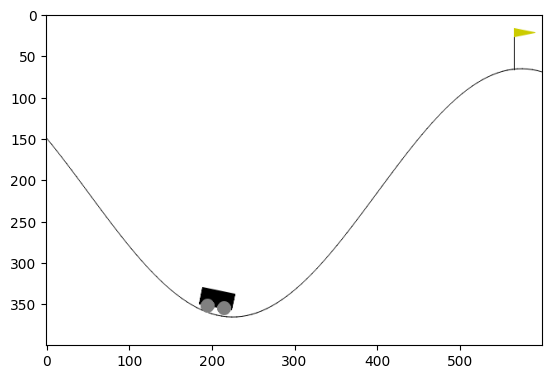

In [4]:
env_screen = env.render()
env.close()

plt.imshow(env_screen)

Now, we can collect all the building blocks, we can create the code the is usually used to run an agent inside an environment. In this toy example, the agent performs random actions, but using algorithms and RL we can make the agent smarter in taking those actions.

In [5]:
import time

# Number of steps you run the agent for
num_steps = 150

env = gym.make('MountainCar-v0', render_mode='human')
obs = env.reset()

for step in range(num_steps):
    # take a random action
    action = env.action_space.sample()

    # apply the action
    obs, reward, done, truncated, info = env.step(action)

    # render the env
    env.render()

    # Wait a bit to see a natural frame sequence
    time.sleep(0.001)

    # in case the episode is done, start another one
    if done:
        env.reset()

# close the env
env.close()

## __Spaces__

Both `action_space` and `observation_space` had different data types (`Box` and `Discrete` respectively). These are types of data structures called "Spaces" provided by Gym.

In [6]:
type(env.observation_space)

gym.spaces.box.Box

In the case of `Box(n,)` , it corresponds to the n-dimensional continuous space. For example, `Box(2,)` corresponds to a 2D space. The value for each dimensions can be bounded and to determine up to which point the environment goes and that's where `env.observation.high` and `env.observation.low` come to play.

On the other hand, the `Discrete(n)` box describes a discrete space with `[0, ..., n-1]` possible values. In the case of the environment, this Discrete variable represents the values our possible actions can take, being this either 0, 1 or 2. Any value of an action out of this "allowed" numbers will result in an error-

In [7]:
# Works
env = gym.make('MountainCar-v0', render_mode='human') 
env.reset()
action = env.action_space.sample()
env.step(action)
print("It works!")

# Does not work
'''
action = env.action_space.sample()
env.step(action+10)
print("It Works")
'''
env.close()

It works!


If for example, we have an environment where we can have several actions, we can use the data type `MultiDiscrete`.

## __Wrappers__

They are used to modify different parts of the environment in order to suit our needs. this could be pixel value normalization for example, in order to input normalized values to our agent.

In [8]:
env = gym.make("BreakoutNoFrameskip-v4", render_mode='human')

print("Observation Space: ", env.observation_space)
print("Action Space       ", env.action_space)


obs = env.reset()

for i in range(100):
    action = env.action_space.sample()
    obs, reward, done, truncated, info = env.step(action)
    env.render()
    time.sleep(0.01)
    if done:
        env.reset()
env.close()

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


Observation Space:  Box(0, 255, (210, 160, 3), uint8)
Action Space        Discrete(4)


/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/home/javiermunoz/miniconda3/envs/pytorch-env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


In our case, we want to store a set of past frames from the environment in order to havce some "memory" of what the agent has done. In order to do that, we are going to concatenate the observations from the space in a deque (doble ended list). To save those observations, we will need the observation space of the environment to be adapted to this, meaning that, instead of only holding in our memory one observation per time-step, holding several the last n-observations space.

In [9]:
from collections import deque
from gym import Env, spaces
import numpy as np

class ConcatObs(gym.Wrapper):
    def __init__(self, env: Env, k):
        super().__init__(env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=((k,) + shp), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob[0])
        return self._get_ob()

    def step(self, action):
        ob, reward, done, truncated, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        return np.array(self.frames)

In [10]:
env = gym.make("BreakoutNoFrameskip-v4")
wrapped_env = ConcatObs(env, 4)
print("The new observation space is", wrapped_env.observation_space)

The new observation space is Box(0, 255, (4, 210, 160, 3), uint8)


In [11]:
# Reset the Env
obs = wrapped_env.reset()
print("Initial obs if of the shape", obs.shape)

# Take one step
obs, _, _, _ = wrapped_env.step(2)
print("Obs after taking a step are", obs.shape)

Initial obs if of the shape (4, 210, 160, 3)
Obs after taking a step are (4, 210, 160, 3)


This wrapper is known as the vanilla wrapper since is generic. There are also specific wrappers that target specific elements of the environment, such as observations, rewards and actions:

1. `ObservationWrapper`: To make changes to the observation using the `observation` method of the wrapper class.
2. `RewardWrapper`: To make changes on the reward the environment returns using the `reward` of the function class.
3. `ActionWrapper`: To make changes to the actions the agent performs on the environment using the `action` function of the wrapper class.

Let's propose 3 ideas to use this methods for changing our environment:
1. Normalize pixel observations from 0-255 to 0-1.
2. Clip the rewards between 0-1
3. Prevent the slider from moving to the left (we don't want action 3 to occurr)

In [12]:
import random
from gym.core import Env

class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env: Env):
        super().__init__(env)
    
    def observation(self, obs):
        # Normalise observation by 255
        return obs/255
   
    
class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env: Env):
        super().__init__(env)

    def reward(self, reward):
        return np.clip(reward, 0, 1)


class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env: Env):
        super().__init__(env)

    def action(self, action):
        if action == 3:
            return random.choice([0,1,2])
        else:
            return action

Let's see our changes in place for the environment.

In [13]:
env = gym.make("BreakoutNoFrameskip-v4", render_mode='human')
# By nesting all the derived classes from the Wrapper class of the environment, we 
# obtain the overrided functionality of all of the classes, obtaining a class that 
# owns all the modified methods.
wrapped_env = ObservationWrapper(RewardWrapper(ActionWrapper(env)))

obs = wrapped_env.reset()

for step in range(100):
    action = wrapped_env.action_space.sample()
    obs, reward, done, truncate, info = wrapped_env.step(action)

    # Raise a flag if values have not been vectorized properly
    if (obs > 1.0).any() or (obs > 0.0).any():
        print("Max and min value of observations out of range")
    # raise a flag if the reward has not been clipped
    if reward < 0.0 or reward > 1.0:
        assert False, "Reward out of bounds"

    if done:
        obs = wrapped_env.reset()

    # Check that the slider do not move to the left
    wrapped_env.render()

    time.sleep(0.001)

wrapped_env.close()
print("All checks passed")
    

Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min value of observations out of range
Max and min v

Finally, we can always return to the unwrapped environment. To do this, we only need to make use of the `unwrapped` attribute of the environment. 

In [14]:
print("Wrapped Env:", wrapped_env)
print("Unwrapped Env", wrapped_env.unwrapped)
print("Getting the meaning of actions", wrapped_env.unwrapped.get_action_meanings())

Wrapped Env: <ObservationWrapper<RewardWrapper<ActionWrapper<OrderEnforcing<PassiveEnvChecker<AtariEnv<BreakoutNoFrameskip-v4>>>>>>>
Unwrapped Env <AtariEnv<BreakoutNoFrameskip-v4>>
Getting the meaning of actions ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


: 